In [2]:
import warnings
warnings.filterwarnings('ignore')

import requests
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn import set_config; set_config(display='diagram')

import shap

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

from mplsoccer import Pitch, VerticalPitch, FontManager

# Analyses on the entire season

In [180]:
# Get the PAx results of 2022/2023 L1 players
# Display PAx of a player on the pitch
# Display PAx of a given match action
# Display SHAP factors to explain a given pass
# Display PAx of a player / a team on the pitch (split by zones)
# Distributuon of PAx for L1 players (or split by strikers...) and position of a given player

# add club logos to barchat : https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib
# display top 5 bottom 5
# display ranking xP to see players who take more risks
# matrix xP / % pass success
# imshow screenshot of a game action with pass info

In [17]:
# Load all passes from last L1 season to train the model

with open("pass_data_2021.pkl", "rb") as input_file:
    df_pass_2021 = pickle.load(input_file)
    
#df_pass_2021 = df_pass_2021.drop(columns=['match_id', 'match_period', 'minute', 'team', 'opponent_team', 'player_name', 'player_id', 'player_position'])
df_pass_2021 = df_pass_2021.drop(columns=['smart_pass', 'carry', 'deep_completed_cross'])

In [4]:
# Load all passes from this current L1 season to apply predictions on

with open("pass_data_2022.pkl", "rb") as input_file:
    df_pass_2022 = pickle.load(input_file)
    
X_predict = df_pass_2022.drop(columns=['match_id', 'match_period', 'minute', 'team', 'opponent_team', 'player_name', 'player_id', 'player_position', 'result'])

In [5]:
num_transformer = Pipeline([('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['float64', 'int64']))],
    remainder='passthrough')

In [6]:
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('lr', LogisticRegression(class_weight={0:85, 1:15}))])
final_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f22bd201430>)])),
                ('lr', LogisticRegression(class_weight={0: 85, 1: 15}))])

In [18]:
X = df_pass_2021.drop(columns=['result'])
y = df_pass_2021[['result']]

In [19]:
final_pipe = final_pipe.fit(X, y)

In [20]:
df_pass_2022 = pd.concat([df_pass_2022.reset_index(drop=True), pd.DataFrame(final_pipe.predict_proba(X_predict))[[1]]], axis=1).rename(columns={1:'xP'})
df_pass_2022['PAx'] = df_pass_2022['result'] - df_pass_2022['xP']

In [21]:
df_pass_2022.head()

,match_id,match_period,minute,team,opponent_team,player_name,player_id,player_position,x_start,y_start,...,previous_event_pass,previous_event_shot_against,previous_event_throw_in,previous_event_touch,height_No,height_high,height_low,result,xP,PAx
0,5359069,1H,0,Monaco,Olympique Marseille,Y. Fofana,525236,RDMF,49.0,50.0,...,0,0,0,0,1,0,0,1,0.346579,0.653421
1,5359069,1H,0,Monaco,Olympique Marseille,W. Ben Yedder,25795,CF,52.0,46.0,...,1,0,0,0,1,0,0,1,0.846913,0.153087
2,5359069,1H,0,Monaco,Olympique Marseille,M. Camara,540846,LDMF,42.0,47.0,...,1,0,0,0,1,0,0,1,0.836212,0.163788
3,5359069,1H,0,Monaco,Olympique Marseille,B. Badiashile,532749,LCB,41.0,28.0,...,1,0,0,0,1,0,0,1,0.441462,0.558538
4,5359069,1H,0,Monaco,Olympique Marseille,A. Golovin,257800,LAMF,65.0,15.0,...,1,0,0,0,1,0,0,0,0.323094,-0.323094


## Focus on xP

In [25]:
with open("minutes_played_2022.pkl", "rb") as input_file:
    df_minutes_played = pickle.load(input_file)

In [33]:
df_pass_2022['total_passes'] = ''
xP_ranked_players = df_pass_2022.groupby(['player_name', 'player_id', 'team']).agg({'xP' : 'mean', 'total_passes' : 'count'}).reset_index()
xP_ranked_players['xP'] = round(xP_ranked_players['xP'],3)
xP_ranked_players = xP_ranked_players.merge(df_minutes_played, on='player_id')
xP_ranked_players = xP_ranked_players.sort_values(by='xP', ascending=False).reset_index(drop=True)
xP_ranked_players = xP_ranked_players[xP_ranked_players['total_minutes_played'] >= 750].reset_index(drop=True)
xP_ranked_players['player_name'] = xP_ranked_players['player_name'] + '         '

In [34]:
xP_ranked_players.head()

,player_name,player_id,team,xP,total_passes,total_minutes_played
0,G. Donnarumma,350999,PSG,0.756,238,1432.0
1,Marquinhos,40539,PSG,0.754,739,1170.0
2,J. Rodon,412919,Rennes,0.753,565,861.0
3,G. Maripán,224080,Monaco,0.748,311,828.0
4,M. Talbi,500509,Lorient,0.743,614,1440.0


In [40]:
empty_df

,player_name,player_id,team,xP,total_passes,total_minutes_played


In [41]:
empty_df = pd.DataFrame({'player_name':[''], 'player_id':[''], 'team':[''],'xP':[0],'total_passes':[0], 'total_minutes_played':[0]})
#empty_df = pd.DataFrame(columns = xP_ranked_players.columns)
xP_ranked_players_plot = pd.concat([xP_ranked_players.head(10), empty_df, xP_ranked_players.tail(10)]).reset_index(drop=True)
xP_ranked_players_plot

,player_name,player_id,team,xP,total_passes,total_minutes_played
0,G. Donnarumma,350999,PSG,0.756,238,1432.0
1,Marquinhos,40539,PSG,0.754,739,1170.0
2,J. Rodon,412919,Rennes,0.753,565,861.0
3,G. Maripán,224080,Monaco,0.748,311,828.0
4,M. Talbi,500509,Lorient,0.743,614,1440.0
5,Tiago Djaló,472669,Lille,0.743,681,1172.0
6,K. Danso,366217,Lens,0.738,855,1447.0
7,J. Jeanvier,28228,Auxerre,0.738,305,766.0
8,C. Jullien,144884,Montpellier,0.730,310,968.0
9,O. Gonzalez,396556,Ajaccio,0.725,343,1022.0


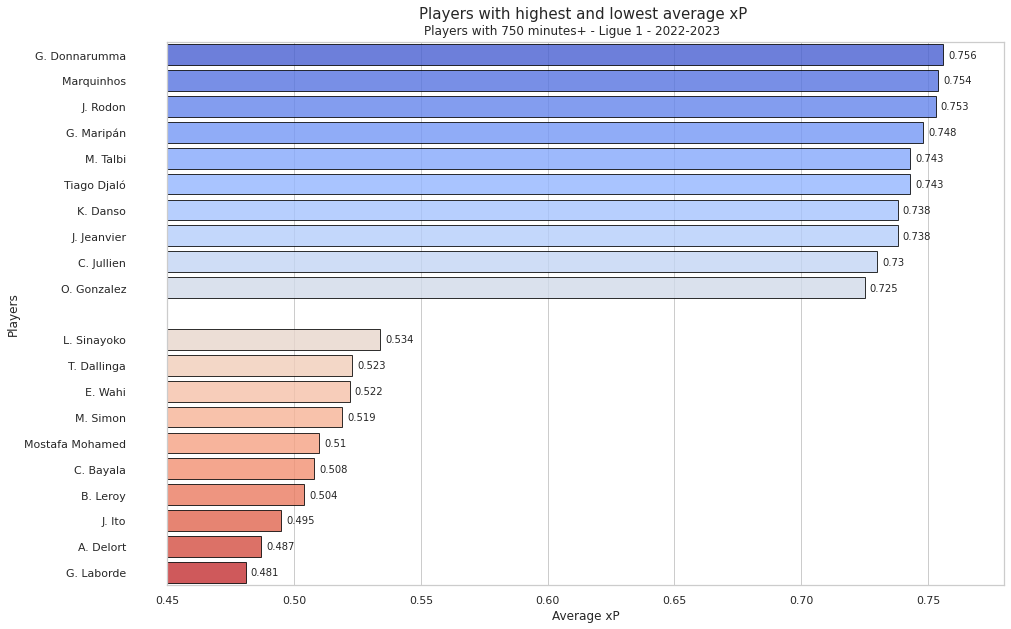

In [44]:
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(15, 10))

#sns.set_color_codes("pastel")
#sns.color_palette("mako", as_cmap=True)
ax = sns.barplot(x='xP',y='player_name', data=xP_ranked_players_plot,palette="coolwarm", saturation=1, alpha=0.8, edgecolor='black', linewidth=1)

for i in ax.containers:
    ax.bar_label(i,size=10, padding=5)
    
plt.xlim(0.45,0.78)
plt.xlabel('Average xP', fontsize=12)
plt.ylabel('Players', fontsize=12)
    
# Set the title
plt.suptitle('Players with 750 minutes+ - Ligue 1 - 2022-2023', y=0.905, fontsize=12)
plt.title('Players with highest and lowest average xP \n', fontsize=15)

plt.savefig("Players xP ranking", bbox_inches='tight', transparent=True)

## Focus on PAx

In [66]:
PAx_ranked_players = df_pass_2022.groupby(['player_name', 'player_id','team']).agg({'PAx' : 'sum', 'total_passes' : 'count'}).reset_index()
PAx_ranked_players['PAx_normalized'] = round(PAx_ranked_players['PAx'].astype('int') * 100 / PAx_ranked_players['total_passes'],2)
PAx_ranked_players = PAx_ranked_players.merge(df_minutes_played, on='player_id')
PAx_ranked_players = PAx_ranked_players.sort_values(by='PAx_normalized', ascending=False).reset_index(drop=True)
PAx_ranked_players = PAx_ranked_players[PAx_ranked_players['total_minutes_played'] >= 750].reset_index(drop=True)
PAx_ranked_players['player_name'] = PAx_ranked_players['player_name'] + '         '
PAx_ranked_players

,player_name,player_id,team,PAx,total_passes,PAx_normalized,total_minutes_played
0,B. Leroy,253312,Ajaccio,57.247125,176,32.39,1275.0
1,L. Chevalier,581660,Lille,51.860065,179,28.49,867.0
2,P. Lees-Melou,277629,Brest,131.256717,480,27.29,1021.0
3,J. Gradit,27944,Lens,148.859388,546,27.11,838.0
4,M. Verratti,21383,PSG,312.303835,1152,27.08,1106.0
...,...,...,...,...,...,...,...
206,R. Ripart,26964,Troyes,35.806649,250,14.00,809.0
207,Y. Diouf,444676,Reims,18.021905,135,13.33,780.0
208,C. Jullien,144884,Montpellier,41.613614,310,13.23,968.0
209,D. Ouattara,698840,Lorient,39.850714,306,12.75,1261.0


In [53]:
PAx_distribution_plot_df = PAx_ranked_players.copy()
PAx_distribution_plot_df['PAx_normalized'] = round(PAx_distribution_plot_df['PAx_normalized'],0)
PAx_distribution_plot_df = pd.concat([pd.DataFrame(PAx_distribution_plot_df.groupby(['PAx_normalized']).cumcount()+1),PAx_distribution_plot_df[['PAx_normalized']]], axis=1).rename(columns={0:'counted'}).reset_index(drop=True)
PAx_distribution_plot_df

,counted,PAx_normalized
0,1,32.0
1,1,28.0
2,1,27.0
3,2,27.0
4,3,27.0
...,...,...
206,4,14.0
207,1,13.0
208,2,13.0
209,3,13.0


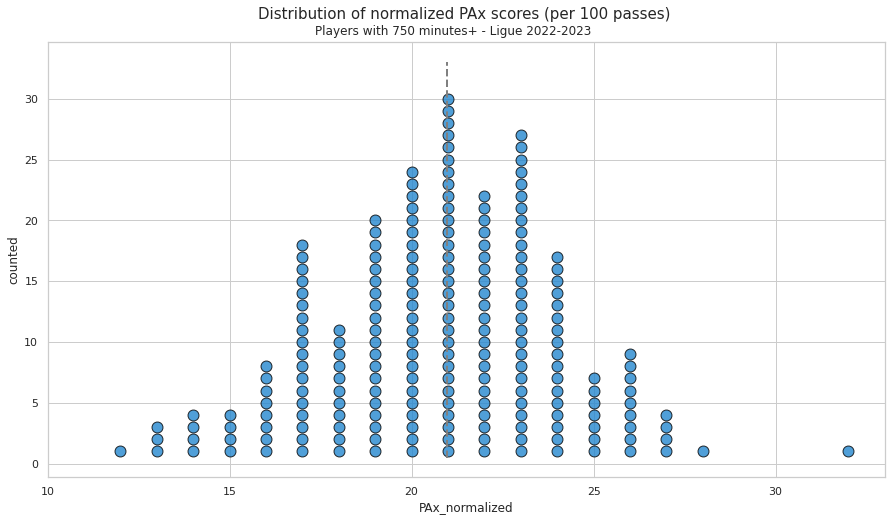

In [58]:
plt.subplots(figsize=(15, 8))


x_median,y_median = [PAx_ranked_players['PAx_normalized'].median(), PAx_ranked_players['PAx_normalized'].median()], [0.5,33]
plt.plot(x_median,y_median, color='grey', linestyle='--', linewidth=2)

sns.scatterplot(x=PAx_distribution_plot_df.PAx_normalized, y=PAx_distribution_plot_df.counted, s=120, alpha=0.8, edgecolor='black', linewidth=1, color ='#2487CF')


plt.xlim(10,33)

plt.suptitle('Players with 750 minutes+ - Ligue 2022-2023', y=0.91, fontsize=12)
plt.title('Distribution of normalized PAx scores (per 100 passes) \n', fontsize=15)

plt.savefig("Distribution of PAx", bbox_inches='tight', transparent=True)

In [59]:
PAx_ranked_players.head()

,player_name,player_id,team,PAx,total_passes,PAx_normalized,total_minutes_played
0,B. Leroy,253312,Ajaccio,57.247125,176,32.39,1275.0
1,L. Chevalier,581660,Lille,51.860065,179,28.49,867.0
2,P. Lees-Melou,277629,Brest,131.256717,480,27.29,1021.0
3,J. Gradit,27944,Lens,148.859388,546,27.11,838.0
4,M. Verratti,21383,PSG,312.303835,1152,27.08,1106.0


In [67]:
empty_df = pd.DataFrame({'player_name':[''], 'player_id':[''], 'team':[''],'PAx':[0],'total_passes':[0], 'PAx_normalized':[0], 'total_minutes_played':[0]})
#empty_df = pd.DataFrame(columns = xP_ranked_players.columns)
PAx_ranked_players_plot = pd.concat([PAx_ranked_players.head(10), empty_df, PAx_ranked_players.tail(10)]).reset_index(drop=True)
PAx_ranked_players_plot

,player_name,player_id,team,PAx,total_passes,PAx_normalized,total_minutes_played
0,B. Leroy,253312,Ajaccio,57.247125,176,32.39,1275.0
1,L. Chevalier,581660,Lille,51.860065,179,28.49,867.0
2,P. Lees-Melou,277629,Brest,131.256717,480,27.29,1021.0
3,J. Gradit,27944,Lens,148.859388,546,27.11,838.0
4,M. Verratti,21383,PSG,312.303835,1152,27.08,1106.0
5,M. El Idrissy,486607,Ajaccio,56.620697,211,26.54,1139.0
6,F. Tardieu,209013,Troyes,154.696021,586,26.28,938.0
7,Vitinha,472577,PSG,164.099318,627,26.16,885.0
8,H. Sakhi,263538,Auxerre,160.082269,612,26.14,1251.0
9,L. Sinayoko,547795,Auxerre,76.165956,292,26.03,905.0


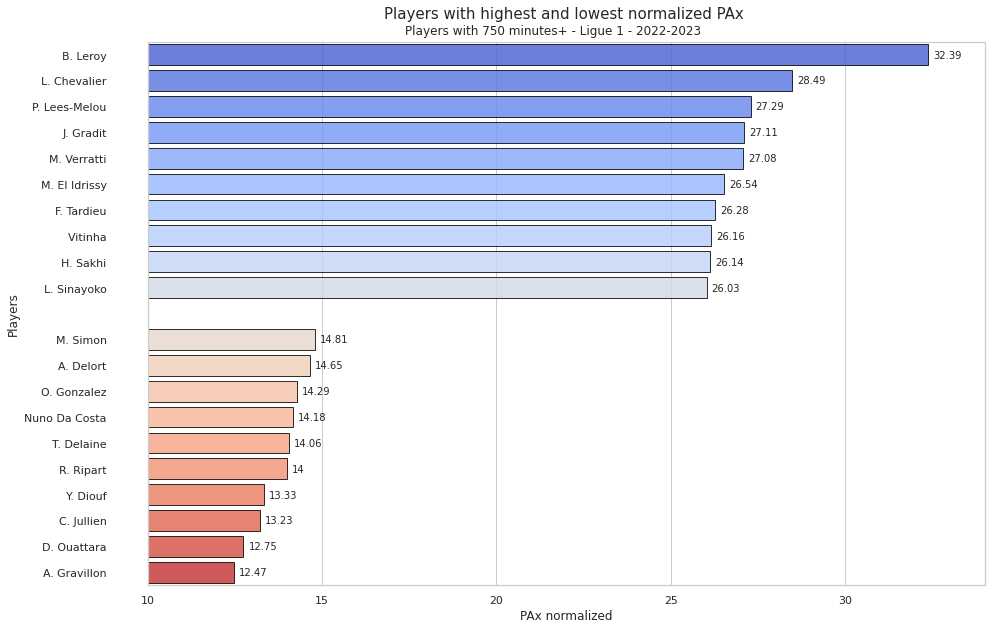

In [69]:
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(15, 10))

#sns.set_color_codes("pastel")
#sns.color_palette("mako", as_cmap=True)
ax = sns.barplot(x='PAx_normalized',y='player_name', data=PAx_ranked_players_plot,palette="coolwarm", saturation=1, alpha=0.8, edgecolor='black', linewidth=1)

for i in ax.containers:
    ax.bar_label(i,size=10, padding=5)
    
plt.xlim(10,34)
plt.xlabel('PAx normalized', fontsize=12)
plt.ylabel('Players', fontsize=12)
    
# Set the title
plt.suptitle('Players with 750 minutes+ - Ligue 1 - 2022-2023', y=0.905, fontsize=12)
plt.title('Players with highest and lowest normalized PAx \n', fontsize=15)

plt.savefig("Players PAx ranking", bbox_inches='tight', transparent=True)

In [72]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

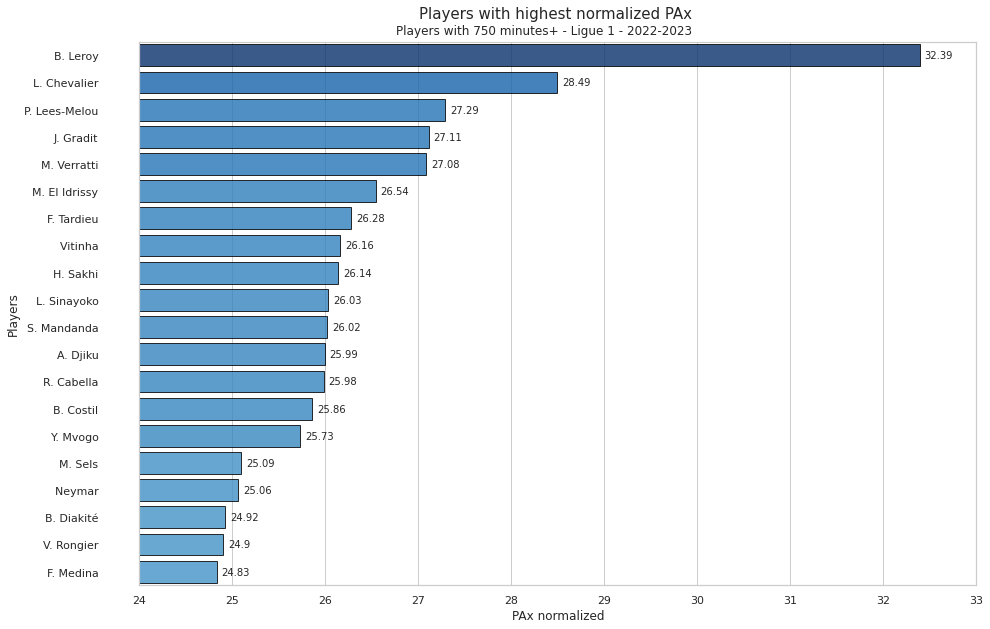

In [76]:
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(15, 10))

#sns.set_color_codes("pastel")
#sns.color_palette("mako", as_cmap=True)
ax = sns.barplot(x='PAx_normalized',y='player_name', data=PAx_ranked_players.head(20) ,palette=colors_from_values(PAx_ranked_players.PAx_normalized, "Blues"), saturation=1, alpha=0.8, edgecolor='black', linewidth=1)

for i in ax.containers:
    ax.bar_label(i,size=10, padding=5)
    
plt.xlim(24,33)
plt.xlabel('PAx normalized', fontsize=12)
plt.ylabel('Players', fontsize=12)
    
# Set the title
plt.suptitle('Players with 750 minutes+ - Ligue 1 - 2022-2023', y=0.905, fontsize=12)
plt.title('Players with highest normalized PAx \n', fontsize=15)

plt.savefig("Top 20 PAx ranking", bbox_inches='tight', transparent=True)

In [79]:
PAx_ranked_teams = df_pass_2022.groupby(['team']).agg({'PAx' : 'sum', 'total_passes' : 'count'}).reset_index()
PAx_ranked_teams['PAx_normalized'] = round(PAx_ranked_teams['PAx'].astype('int') * 100 / PAx_ranked_teams['total_passes'],2)
PAx_ranked_teams = PAx_ranked_teams.sort_values(by='PAx_normalized', ascending=False).reset_index(drop=True)
PAx_ranked_teams['team'] = PAx_ranked_teams['team'] + '         '
PAx_ranked_teams

,team,PAx,total_passes,PAx_normalized
0,PSG,2204.521508,9310,23.67
1,Lille,1677.725974,7502,22.35
2,Lens,1655.802689,7495,22.08
3,Olympique Lyonnais,1780.672990,8130,21.89
4,Rennes,1594.031942,7359,21.66
5,Strasbourg,1349.096091,6265,21.53
6,Monaco,1230.564597,5723,21.49
7,Toulouse,1307.000482,6121,21.35
8,Olympique Marseille,1490.399249,7018,21.23
9,Ajaccio,1103.578090,5265,20.95


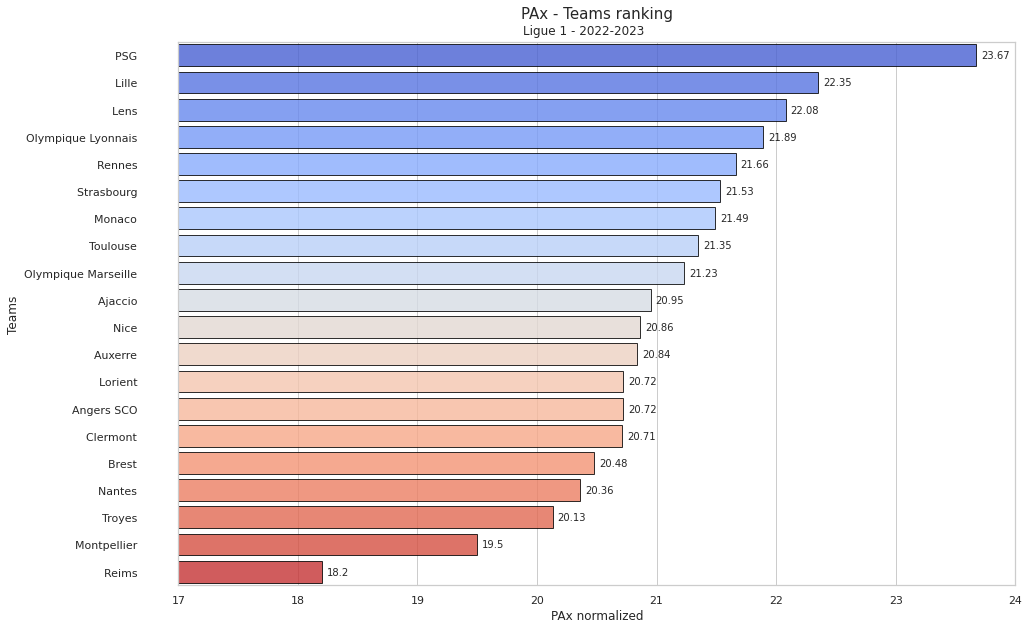

In [82]:
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(15, 10))

#sns.set_color_codes("pastel")
#sns.color_palette("mako", as_cmap=True)
ax = sns.barplot(x='PAx_normalized',y='team', data=PAx_ranked_teams ,palette="coolwarm", saturation=1, alpha=0.8, edgecolor='black', linewidth=1)

for i in ax.containers:
    ax.bar_label(i,size=10, padding=5)
    
plt.xlim(17,24)
plt.xlabel('PAx normalized', fontsize=12)
plt.ylabel('Teams', fontsize=12)
    
# Set the title
plt.suptitle('Ligue 1 - 2022-2023', y=0.905, fontsize=12)
plt.title('PAx - Teams ranking\n', fontsize=15)

plt.savefig("Teams ranking PAx", bbox_inches='tight', transparent=True)

# Analyses on a match

In [91]:
# Here ASM vs OM - 13 November 2022 (match_id : 5359069)

from Data_preparation import *

match_id = ['5359069']

df_match = load_and_prepare_pass_data(match_id, 'bGpxc3lkYi00a29uMGQ1dzEtaTZ2bzRzdi1rdjQzbnNncWxiOkdKNWREZzAjeSxxRERZTG86QHZqTFB2YjVDWUFxQQ==')

df_match = change_column_type(df_match)

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


In [93]:
with open("game_data.pkl", "rb") as input_file:
    df_match = pickle.load(input_file)

In [94]:
df_match.head()

,match_id,match_period,minute,team,opponent_team,player_name,player_id,player_position,x_start,y_start,...,previous_event_goal_kick,previous_event_interception,previous_event_pass,previous_event_shot_against,previous_event_throw_in,previous_event_touch,height_No,height_high,height_low,result
0,5359069,1H,0,Monaco,Olympique Marseille,Y. Fofana,525236,RDMF,49.0,50.0,...,0,0,0,0,0,0,1,0,0,1
1,5359069,1H,0,Monaco,Olympique Marseille,W. Ben Yedder,25795,CF,52.0,46.0,...,0,0,1,0,0,0,1,0,0,1
2,5359069,1H,0,Monaco,Olympique Marseille,M. Camara,540846,LDMF,42.0,47.0,...,0,0,1,0,0,0,1,0,0,1
3,5359069,1H,0,Monaco,Olympique Marseille,B. Badiashile,532749,LCB,41.0,28.0,...,0,0,1,0,0,0,1,0,0,1
4,5359069,1H,0,Monaco,Olympique Marseille,A. Golovin,257800,LAMF,65.0,15.0,...,0,0,1,0,0,0,1,0,0,0


In [95]:
 X_predict = df_match.drop(columns=['match_id', 'match_period', 'minute', 'team', 'opponent_team', 'player_name', 'player_id', 'player_position', 'result'])

In [96]:
df_match = pd.concat([df_match.reset_index(drop=True), pd.DataFrame(final_pipe.predict_proba(X_predict))[[1]]], axis=1).rename(columns={1:'xP'})
df_match['PAx'] = df_match['result'] - df_match['xP']

In [97]:
# Focus on the actions preceding the 2nd OM goal (Veretout - 83')

df_match.iloc[783:796,:]

,match_id,match_period,minute,team,opponent_team,player_name,player_id,player_position,x_start,y_start,...,previous_event_pass,previous_event_shot_against,previous_event_throw_in,previous_event_touch,height_No,height_high,height_low,result,xP,PAx
783,5359069,2H,82,Olympique Marseille,Monaco,J. Veretout,25541,RCMF,59.0,75.0,...,0,0,0,0,1,0,0,1,0.783564,0.216436
784,5359069,2H,82,Olympique Marseille,Monaco,C. Mbemba,37726,RCB3,56.0,74.0,...,0,0,0,1,1,0,0,1,0.826747,0.173253
785,5359069,2H,82,Olympique Marseille,Monaco,L. Balerdi,575036,CB,43.0,64.0,...,1,0,0,0,1,0,0,1,0.846191,0.153809
786,5359069,2H,82,Olympique Marseille,Monaco,P. Gueye,460552,LCMF,57.0,17.0,...,0,0,0,1,1,0,0,1,0.457989,0.542011
787,5359069,2H,82,Olympique Marseille,Monaco,Nuno Tavares,532604,LWB,71.0,21.0,...,0,0,0,1,1,0,0,1,0.567116,0.432884
788,5359069,2H,82,Olympique Marseille,Monaco,D. Payet,25714,AMF,70.0,36.0,...,1,0,0,0,1,0,0,1,0.617321,0.382679
789,5359069,2H,82,Olympique Marseille,Monaco,A. Sánchez,3361,AMF,70.0,52.0,...,1,0,0,0,1,0,0,1,0.546120,0.453880
790,5359069,2H,82,Olympique Marseille,Monaco,D. Payet,25714,AMF,77.0,64.0,...,1,0,0,0,1,0,0,1,0.734498,0.265502
791,5359069,2H,82,Olympique Marseille,Monaco,A. Sánchez,3361,AMF,70.0,55.0,...,1,0,0,0,1,0,0,1,0.775204,0.224796
792,5359069,2H,82,Olympique Marseille,Monaco,P. Gueye,460552,LCMF,66.0,36.0,...,1,0,0,0,1,0,0,1,0.820877,0.179123


Text(63.0, 34.5, 'P. Gueye : 0.821')

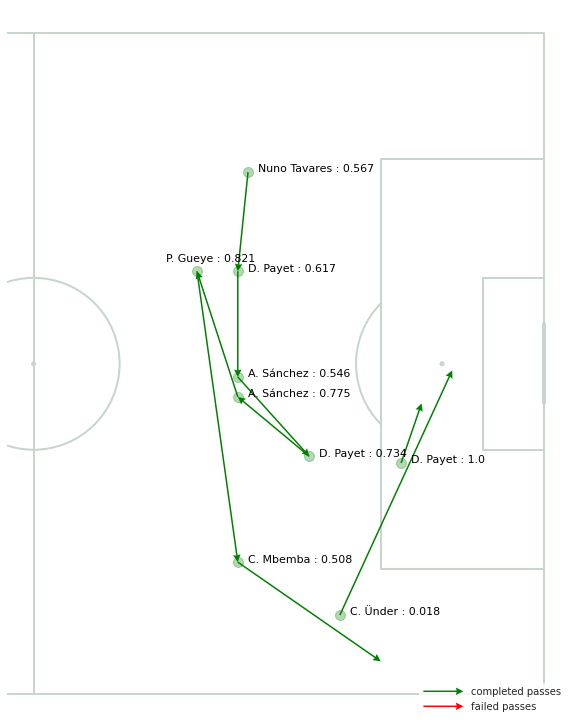

In [99]:
# ASM vs OM action focus

action_focus = df_match.iloc[787:796,:]

pass_accurate = action_focus[(action_focus['result'] == 1)]
pass_failed = action_focus[(action_focus['result'] == 0)]

# Set up the pitch
pitch = Pitch(pitch_type='wyscout', pitch_color='white', line_color='#c7d5cc', half=True)
fig, ax = pitch.draw(figsize=(20, 10), constrained_layout=True, tight_layout=False)
#fig.set_facecolor('#22312b')

# Plot the completed passes
pitch.arrows(pass_accurate.x_start, pass_accurate.y_start,
             pass_accurate.x_end, pass_accurate.y_end, width=1.5,
             headwidth=5, headlength=5, color='green', ax=ax, label='completed passes')

pitch.scatter(pass_accurate.x_start, pass_accurate.y_start,color="green", ax=ax, s=100, alpha=0.3)

# Plot the other passes
pitch.arrows(pass_failed.x_start, pass_failed.y_start,
             pass_failed.x_end, pass_failed.y_end, width=1.5,
             headwidth=5, headlength=5, color='red', ax=ax, label='failed passes')
pitch.scatter(pass_failed.x_start, pass_failed.y_start,color="red", ax=ax, s=100, alpha=0.3)

# Set up the legend
ax.legend(facecolor='white', handlelength=4, edgecolor='None', fontsize=10, loc='lower right')

action_labels = action_focus.drop(index=792)
for index, row in action_labels.iterrows():
    ax.annotate(f"{action_labels.loc[index,'player_name']} : {round(action_labels.loc[index,'xP'],3)}", (action_labels.loc[index,'x_start']+1, action_labels.loc[index,'y_start']), fontsize=11, color = 'black')
ax.annotate(f"{action_focus.loc[792,'player_name']} : {round(action_focus.loc[792,'xP'],3)}", (action_focus.loc[792,'x_start']-3, action_focus.loc[792,'y_start']-1.5), fontsize=11, color = 'black')
# Set the title
#ax_title = ax.set_title(f'{team1} passes vs {team2}', fontsize=10)

#plt.savefig("Goal action 83' 2-2", bbox_inches='tight', transparent=True)

In [101]:
# Fits the explainer
explainer = shap.Explainer(final_pipe.predict, X_predict)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_predict)

Permutation explainer: 914it [01:05, 12.05it/s]                         


In [347]:
shap_values.values[794]

array([ 0.04833333, -0.0025    ,  0.        ,  0.00166667,  0.        ,
        0.03083333, -0.14      ,  0.00333333,  0.005     , -0.01      ,
       -0.00416667, -0.21583333, -0.015     ,  0.00333333, -0.00166667,
        0.00083333, -0.00083333,  0.01166667,  0.        ,  0.015     ,
        0.        , -0.1675    , -0.04083333, -0.05333333,  0.0275    ,
       -0.00166667,  0.        ,  0.00083333,  0.00333333, -0.0125    ,
       -0.00333333,  0.        ,  0.        , -0.0225    , -0.00083333,
       -0.00666667, -0.00166667, -0.48583333,  0.255     ,  0.        ])

In [348]:
shap_values.base_values[794]

0.78

In [349]:
shap_values[794]

.values =
array([ 0.04833333, -0.0025    ,  0.        ,  0.00166667,  0.        ,
        0.03083333, -0.14      ,  0.00333333,  0.005     , -0.01      ,
       -0.00416667, -0.21583333, -0.015     ,  0.00333333, -0.00166667,
        0.00083333, -0.00083333,  0.01166667,  0.        ,  0.015     ,
        0.        , -0.1675    , -0.04083333, -0.05333333,  0.0275    ,
       -0.00166667,  0.        ,  0.00083333,  0.00333333, -0.0125    ,
       -0.00333333,  0.        ,  0.        , -0.0225    , -0.00083333,
       -0.00666667, -0.00166667, -0.48583333,  0.255     ,  0.        ])

.base_values =
0.78

.data =
array([ 80.   ,  88.   ,   1.611,   1.   , -64.   ,  28.   ,  91.   ,
        51.   ,  12.   ,   0.   ,   0.   ,   1.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   1.   ,   0.   ,   0.   ,   0.   ,
         1.   ,   1.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   1.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,

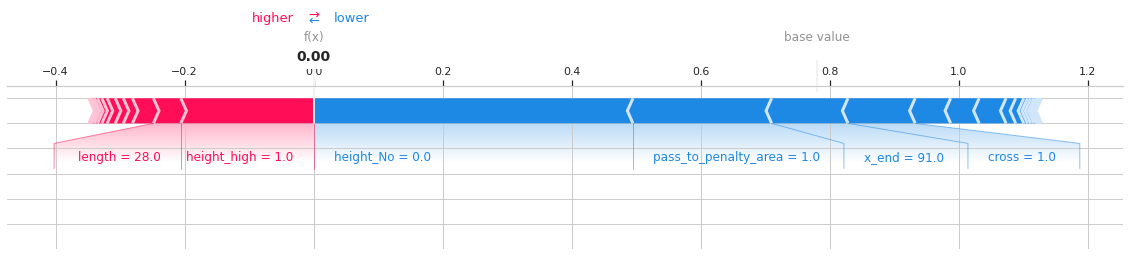

In [105]:
shap.plots.force(shap_values[794], matplotlib=True)

plt.savefig("Under pass 83'.png", dpi=150, bbox_inches='tight', transparent=True)

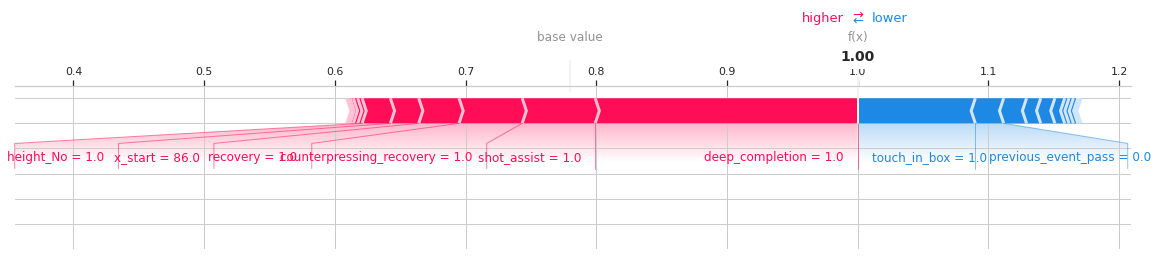

<Figure size 432x288 with 0 Axes>

In [107]:
shap.plots.force(shap_values[795], matplotlib=True)

plt.savefig("Payet pass 83'.png", dpi=150, bbox_inches='tight', transparent=True)